In [21]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, utils
import torch.optim as optim

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


##Dataset Preparation

In [22]:
# Function to create stratified train/val/test splits
def create_stratified_splits(source_dir, target_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create stratified train/val/test splits with folder structure
    """
    # Create target directories
    for split in ['train', 'val', 'test']:
        for class_name in ['with_mask', 'without_mask']:
            os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)
    
    # Process each class
    for class_name in ['with_mask', 'without_mask']:
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist")
            continue
            
        # Get all image files
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # First split: train vs temp (val+test)
        train_imgs, temp_imgs = train_test_split(
            images, 
            train_size=train_ratio, 
            random_state=42,
            stratify=[class_name] * len(images)  # All same class for stratification
        )
        
        # Second split: val vs test
        val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
        val_imgs, test_imgs = train_test_split(
            temp_imgs, 
            train_size=val_ratio_adjusted, 
            random_state=42,
            stratify=[class_name] * len(temp_imgs)  # All same class for stratification
        )
        
        # Copy images to respective directories
        for img in train_imgs:
            shutil.copy2(
                os.path.join(class_dir, img),
                os.path.join(target_dir, 'train', class_name, img)
            )
        
        for img in val_imgs:
            shutil.copy2(
                os.path.join(class_dir, img),
                os.path.join(target_dir, 'val', class_name, img)
            )
        
        for img in test_imgs:
            shutil.copy2(
                os.path.join(class_dir, img),
                os.path.join(target_dir, 'test', class_name, img)
            )
            
        print(f"Class {class_name}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test images")

# Create the stratified splits (run this once)
# create_stratified_splits('data', 'FMD_data')

In [23]:
# Dataset class
class FaceMaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {'with_mask': 0, 'without_mask': 1}
        self.idx_to_class = {0: 'with_mask', 1: 'without_mask'}

        # Load images and labels
        for class_name in self.class_to_idx.keys():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    def get_class_distribution(self):
        """Return the distribution of classes in the dataset"""
        distribution = defaultdict(int)
        for label in self.labels:
            class_name = self.idx_to_class[label]
            distribution[class_name] += 1
        return distribution

In [24]:
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

In [25]:
# Create datasets
train_dataset = FaceMaskDataset(root_dir='FMD_data/train', transform=data_transforms['train'])
val_dataset = FaceMaskDataset(root_dir='FMD_data/val', transform=data_transforms['val'])
test_dataset = FaceMaskDataset(root_dir='FMD_data/test', transform=data_transforms['test'])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("\nClass distribution:")
print("Train:", dict(train_dataset.get_class_distribution()))
print("Val:", dict(val_dataset.get_class_distribution()))
print("Test:", dict(test_dataset.get_class_distribution()))

Training samples: 5286
Validation samples: 1133
Test samples: 1134

Class distribution:
Train: {'with_mask': 2607, 'without_mask': 2679}
Val: {'with_mask': 559, 'without_mask': 574}
Test: {'with_mask': 559, 'without_mask': 575}


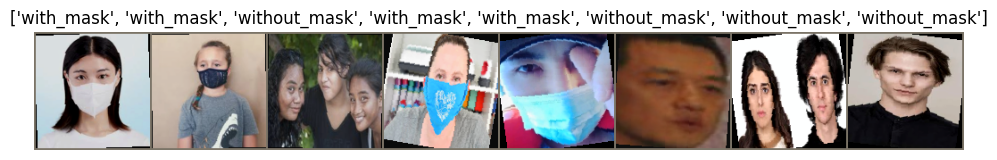

In [26]:
# Visualize some images from the dataset
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch (max 8 images)
max_images = min(8, inputs.size(0))
out = utils.make_grid(inputs[:max_images])

class_names = ['with_mask', 'without_mask']
plt.figure(figsize=(12, 6))
imshow(out, title=[class_names[x] for x in classes[:max_images]])
plt.show()

In [27]:
# Model architecture
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes=2):
        super(ClassifierHead, self).__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class FaceMaskClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(FaceMaskClassifier, self).__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256)
        )
        
        # Calculate the size of the feature maps
        self._initialize_weights()
        
        # Dummy input to calculate feature size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            dummy_output = self.features(dummy_input)
            self.feature_size = dummy_output.view(1, -1).size(1)
        
        self.classifier = ClassifierHead(self.feature_size, num_classes)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model
model = FaceMaskClassifier(num_classes=2).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

Model initialized with 8,780,546 parameters


In [28]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        scheduler.step()

        # Early stopping check
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            epochs_without_improvement = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        print('-' * 20)

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return train_losses, val_losses, train_accs, val_accs

In [29]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
num_epochs = 25
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)


c:\Users\13th\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/25:
Train Loss: 0.3037, Train Acc: 0.8774
Val Loss: 0.2143, Val Acc: 0.9206
--------------------
Epoch 2/25:
Train Loss: 0.1890, Train Acc: 0.9228
Val Loss: 0.4217, Val Acc: 0.8305
--------------------
Epoch 3/25:
Train Loss: 0.1543, Train Acc: 0.9404
Val Loss: 0.1609, Val Acc: 0.9409
--------------------
Epoch 4/25:
Train Loss: 0.1416, Train Acc: 0.9459
Val Loss: 0.1027, Val Acc: 0.9638
--------------------
Epoch 5/25:
Train Loss: 0.1090, Train Acc: 0.9622
Val Loss: 0.0911, Val Acc: 0.9665
--------------------
Epoch 6/25:
Train Loss: 0.1070, Train Acc: 0.9618
Val Loss: 0.0909, Val Acc: 0.9673
--------------------
Epoch 7/25:
Train Loss: 0.0936, Train Acc: 0.9654
Val Loss: 0.1359, Val Acc: 0.9479
--------------------
Epoch 8/25:
Train Loss: 0.0873, Train Acc: 0.9661
Val Loss: 0.0707, Val Acc: 0.9771
--------------------
Epoch 9/25:
Train Loss: 0.0852, Train Acc: 0.9695
Val Loss: 0.1347, Val Acc: 0.9444
--------------------
Epoch 10/25:
Train Loss: 0.0714, Train Acc: 0.9739
Val 

In [30]:
# from google.colab import drive
# drive.mount('/content/drive')

In [31]:
!pip install tensorflow tf2onnx onnx onnxruntime

INFO: pip is looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
  Using cached tf2onnx-1.16.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.15.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.15.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.14.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.13.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.12.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.12.0-py3-none-any.whl.metadata (1.2 kB)
INFO: pip is still looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
  Using cached tf2onnx-1.11.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.10.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.9.3-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.9.2-py3-none-any.whl.metadata (1

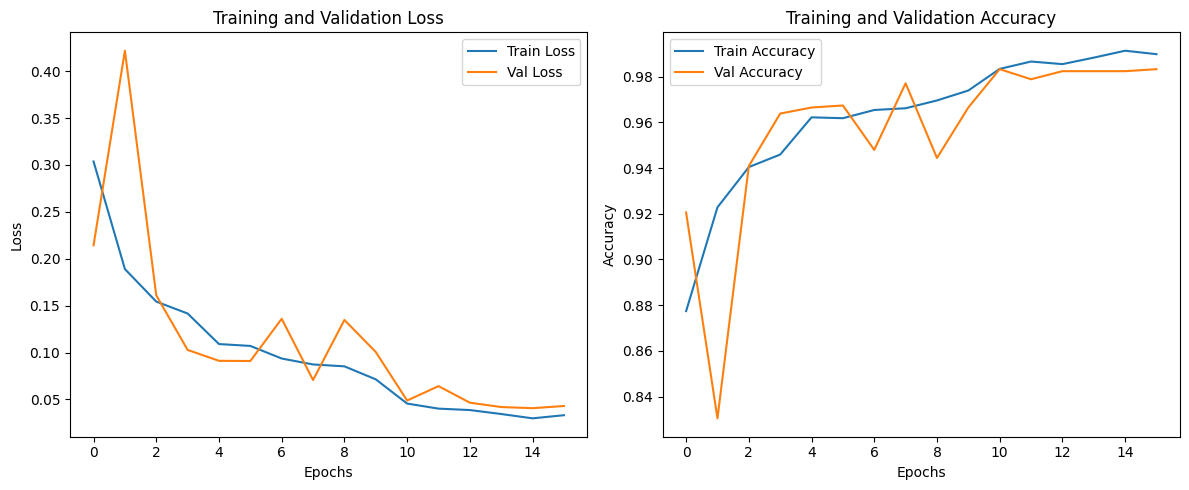

In [32]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Calculate class-wise accuracy
    class_correct = [0, 0]
    class_total = [0, 0]
    for i in range(len(all_labels)):
        label = all_labels[i]
        pred = all_preds[i]
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1
            
    print("\nClass-wise accuracy:")
    for i in range(2):
        class_name = "with_mask" if i == 0 else "without_mask"
        print(f"{class_name}: {class_correct[i] / class_total[i]:.4f} ({class_correct[i]}/{class_total[i]})")

    return all_preds, all_labels, all_probs, accuracy

# Evaluate the model on test set
test_predictions, test_labels, test_probs, test_accuracy = evaluate_model(model, test_loader)

Test Accuracy: 0.9762

Class-wise accuracy:
with_mask: 0.9803 (548/559)
without_mask: 0.9722 (559/575)


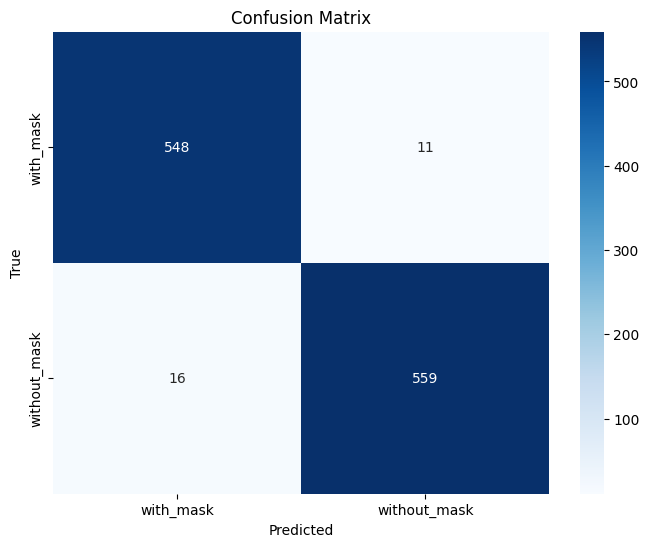

In [34]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_predictions, ['with_mask', 'without_mask'])

In [35]:
# Prediction function
def predict_image(model, image_path, transform):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Get class label and confidence
    class_names = ['with_mask', 'without_mask']
    predicted_class = class_names[predicted.item()]
    confidence = probs[0][predicted.item()].item()

    return predicted_class, confidence, probs.cpu().numpy()[0]

# Example usage
# prediction, confidence, all_probs = predict_image(model, 'path/to/image.jpg', data_transforms['val'])
# print(f'Prediction: {prediction}, Confidence: {confidence:.4f}')
# print(f'Class probabilities: {all_probs}')

In [36]:
# Save the trained model
torch.save(model.state_dict(), 'face_mask_model.pth')

# Save the class names
class_names = ['with_mask', 'without_mask']
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# Save the complete model for later use
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'input_size': (128, 128),
    'test_accuracy': test_accuracy
}, 'complete_face_mask_model.pth')

print("Model and related files saved successfully!")

Model and related files saved successfully!


In [37]:
# Export to ONNX
def export_to_onnx(model, input_size=(128, 128), output_path='face_mask_model.onnx'):
    model.eval()

    # Create a dummy input with the correct shape
    dummy_input = torch.randn(1, 3, input_size[0], input_size[1]).to(device)

    # Export the model
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"Model exported to {output_path}")

# Export to ONNX
export_to_onnx(model)

C:\Users\13th\AppData\Local\Temp\ipykernel_33064\2487940255.py:9: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Model exported to face_mask_model.onnx
